In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

from scripts.imagedata import ImageData
from scripts.model import Net
from scripts.msenet import MSENet
from scripts.config import device, PATH_TO_MCINTOSH

Display fits

In [6]:
from ipywidgets import interact

@interact(filename=os.listdir(PATH_TO_MCINTOSH))
def show_image(filename):
    img_data = ImageData(os.path.join(PATH_TO_MCINTOSH, filename), 'fits')
    img_data.show_image()
    plt.figure(figsize=(10, 5))
    plt.imshow(img_data.target_img, cmap='PuOr')
    plt.title('Target image')
    plt.show()

interactive(children=(Dropdown(description='filename', options=('ptmc_compo_sm_19541221_150036_cr1355k_l3.fits…

# No pretrain

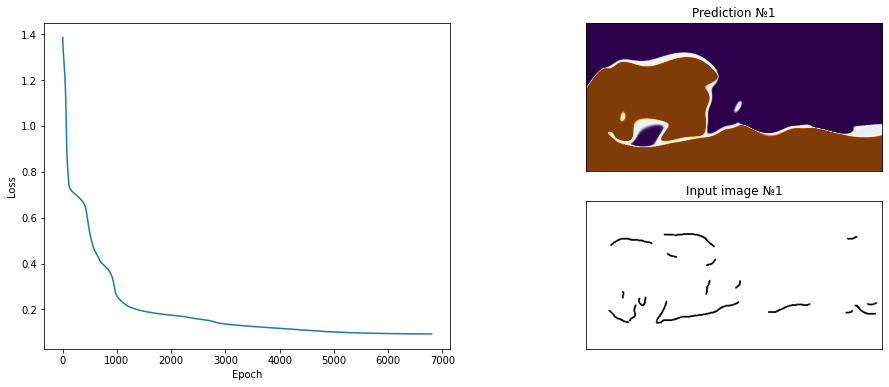

KeyboardInterrupt: 

In [8]:
filenames = os.listdir(PATH_TO_MCINTOSH)[:28]

num_epochs = 10000
arch = [3, 6, 12, 24, 12, 6, 3, 1]
lr = 1e-3
weight_decay = 1e-4

for filename in filenames:
    model = Net(image_list=[ImageData(path_or_img=os.path.join(PATH_TO_MCINTOSH, filename), data_mode='fits')],
                lr=lr, arch=arch, mode='3d', weight_decay=weight_decay)
    model.to(device)
    model.start_training(num_epochs=num_epochs, need_plot=True, need_save=False)

# Pretrain with MSENet on first 28 maps

In [18]:
filenames = os.listdir(PATH_TO_MCINTOSH)[:28]
n_tryes = 5
num_epochs = 30000
arch = [3, 6, 12, 24, 12, 6, 3, 1]
lr = 1e-3
weight_decay = 1e-4

path_to_save = 'Tests/Fits/MSEnet/'
os.makedirs(path_to_save, exist_ok=True)

In [ ]:
for i, filename in enumerate(filenames):
    print(f'Map {i+1}/{len(filenames)}')
    for j in range(n_tryes):
        print(f'Try {j+1}/4')
        imgdata = ImageData(path_or_img=os.path.join(PATH_TO_MCINTOSH, filename), data_mode='fits')
        imgdata.img_array = imgdata.target_img
        msenet = MSENet(img=imgdata, arch=arch, mode='3d')
        msenet.to(device)
        msenet.train(num_epochs=num_epochs,
                     need_plot=False,
                     lr=lr,
                     weight_decay=weight_decay)
        torch.save(msenet.state_dict(), path_to_save + f'model_{i}_try_{j}.pt')
        prediction = msenet(imgdata.data_3d.to(device)).cpu().detach().view(256, 512).numpy()
        plt.figure(figsize=(20, 6))
        plt.suptitle(f'File: {filename}\narch: {arch}\nloss: {msenet.loss_dict[-1]:.4f}\nnum_epochs: {num_epochs}, lr: {lr}, weight_decay: {weight_decay}, Try: {j}')
        plt.subplot(1, 2, 1)
        plt.imshow(imgdata.target_img, cmap='PuOr')
        plt.title('Target')
        plt.subplot(1, 2, 2)
        plt.imshow(prediction, cmap='PuOr')
        plt.title('Prediction')
        plt.savefig(path_to_save + f'img_{i}_try_{j}.png', bbox_inches='tight', pad_inches=0, facecolor='white')


# Use pretrained weights

In [4]:
path_to_pretrained_weights = './state_dict/fits/first28/'
filenames = os.listdir(PATH_TO_MCINTOSH)[1:28]
weights = os.listdir(path_to_pretrained_weights)[:-1]

num_epochs = 5
arch = [3, 6, 12, 24, 12, 6, 3, 1]
lr = 1e-2
weight_decay = 1e-3

os.makedirs(path_to_save, exist_ok=True)


In [ ]:
i=1
for path_to_weight, filename in tqdm(zip(weights, filenames)):
    model = Net(image_list=[ImageData(path_or_img=os.path.join(PATH_TO_MCINTOSH, filename), data_mode='fits')],
                lr=lr, arch=arch, mode='3d', weight_decay=weight_decay)
    model.to(device)
    model.load_state_dict(torch.load(os.path.join(path_to_pretrained_weights, path_to_weight)))
    start_state = model.test_model()[0]

    model.start_training(num_epochs=num_epochs,
                need_plot=True,
                need_save=False)
    model.save_state_dict(path_to_save + f'model_{i}.pt')
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(model.image_list[0].img_array, cmap='PuOr', vmin=-1, vmax=1)
    plt.title('Input image with filaments')
    plt.subplot(2, 2, 2)
    plt.imshow(model.image_list[0].target_img, cmap='PuOr')
    plt.title('Target image')
    plt.subplot(2, 2, 3)
    plt.imshow(start_state.view(256, 512), cmap='PuOr')
    plt.title('Start state')
    plt.subplot(2, 2, 4)
    plt.imshow(model.test_model()[0].view(256, 512), cmap='PuOr')
    plt.title('Prediction')
    plt.tight_layout()
    plt.savefig(path_to_save + f'model_{i}', bbox_inches='tight', pad_inches=0, facecolor='white')
    i+=1
